# Exoplanets HW 2
Jake Lustig-Yaeger and David Fleming solution

Make sure ExoJulia is in our path.

In [36]:
push!(LOAD_PATH, "../../../ExoJulia/")

4-element Array{ByteString,1}:
 "/Applications/Julia-0.4.5.app/Contents/Resources/julia/local/share/julia/site/v0.4"
 "/Applications/Julia-0.4.5.app/Contents/Resources/julia/share/julia/site/v0.4"      
 "../../../ExoJulia/"                                                                
 "../../../ExoJulia/"                                                                

Make sure to include relevant packages and our code!

In [110]:
using ExoJulia
using PyPlot
using LsqFit

In [38]:
include("utils.jl")
include("orbital_utils.jl")
include("rv.jl")

agol_periodogram (generic function with 1 method)

### Read-in Mystery RV data

In [39]:
numbers = readdlm("mystery_planet.txt");

In [40]:
time = numbers[:,1];
rv = numbers[:,2];
err = numbers[:,end];

Plot it to see if there's any trend.

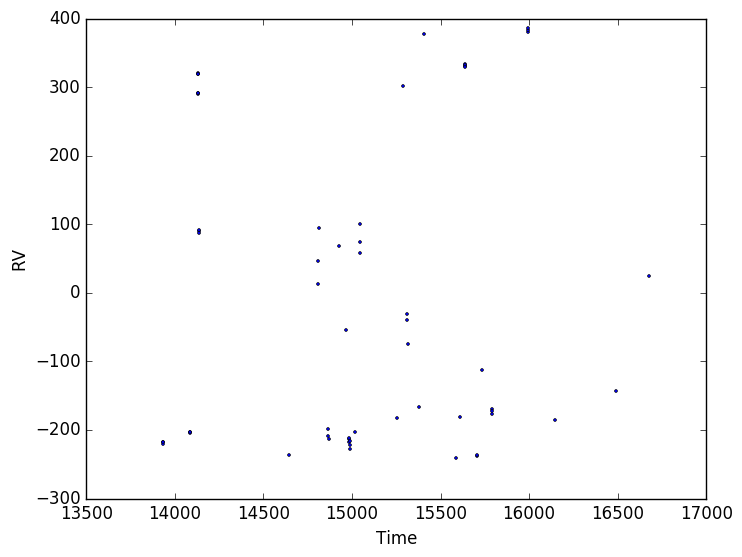

PyObject <matplotlib.text.Text object at 0x31349d450>

In [41]:
plot(time, rv, "o", ms=2.0)
xlabel("Time")
ylabel("RV")

## Period Fitting

There's no obvious trend in the data, so we'll see if we can back our way into a period.  Using Eric's suggestion for data with small error bars, loop over a grid of periods and sort the RV points by phase.  Then, take the sum of squares of differences of successive points and find the period that corresponds to the smallest sum.  This method will be a useful means to guess the period later on for more robust fitting.

### Agol Method

In [114]:
periods = linspace(1.0, 365.0, 2000)

linspace(1.0,365.0,2000)

In [115]:
p = collect(periods);

In [116]:
@time best_period = agol_periodogram(numbers, p)
# [time rv err]

116.62781390695348

0.052119 seconds (60.01 k allocations: 17.414 MB, 6.09% gc time)


## RV Fitting

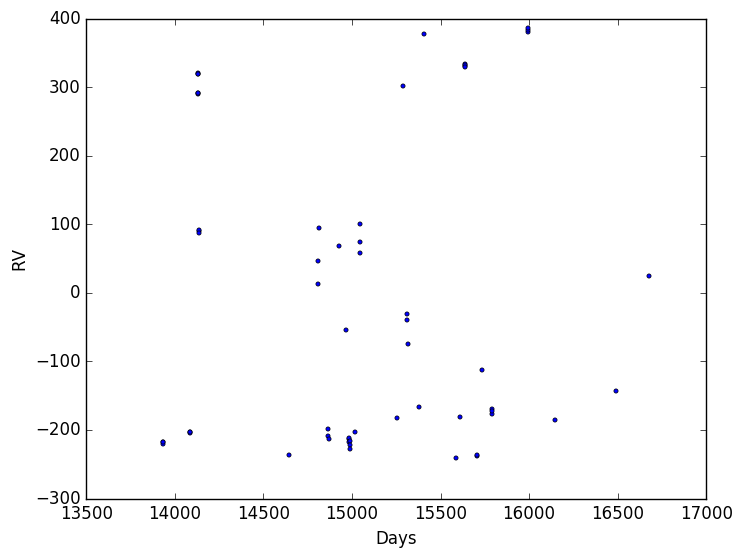

PyObject <matplotlib.text.Text object at 0x31434a950>

In [109]:
plot(numbers[:,1], numbers[:,2], "o", ms=3)
xlabel("Days")
ylabel("RV")

In [108]:
function fit_to_physical(e::Float64,h::Float64,c::Float64,v0::Float64)
    w = atan(-c/h)
    K = h / cos(w)
    
    return w, K
end

fit_to_physical (generic function with 2 methods)

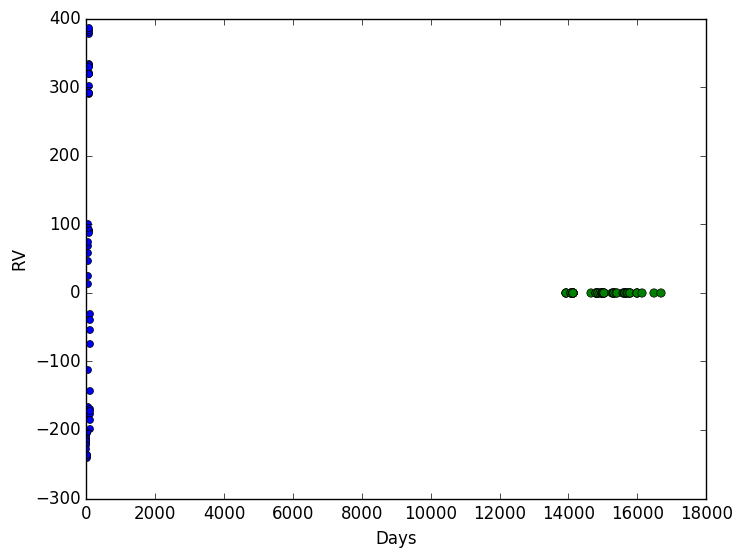

PyObject <matplotlib.text.Text object at 0x313d0f8d0>

In [61]:
plot(numbers[:,1], numbers[:,2], "o", ms=5)
plot(time_fold, vrad_fit, "o")
xlabel("Days")
ylabel("RV")